### Dataset

#### experimental structure
5 runs <br>
12 trials per run <br>
4 conditions 
- cond 1: low GO, low U
- cond 2: low GO, high U
- cond 3: high GO, low U
- cond 4: high GO, high U <br>

No_subs = 49

No_conditions = 6 <br>
6 types of events per trial <br>
list of conditions: 'caught', 'chase', 'checkpoint', 'close_enemy', 'protected_by_wall', 'vc_hit' <br>

#### possibilities of modelling data per sub
- __one beta map per run__
- one beta map per x trials, x={1,2,3,6}
- one beta map per condition --> we will model conditions rather than the events within a trial

#### tutorial link
https://peerherholz.github.io/workshop_weizmann/advanced/machine_learning_nilearn.html

In [1]:
import nibabel as nib
import os
import numpy as np

In [2]:
# load beta images
# And clean them, replacing nans by 0s ...
from nilearn.image import clean_img
beta_maps_dir = 'data/beta_maps'
beta_maps = []
for file in sorted(os.listdir(beta_maps_dir)):
    if file.endswith('.nii.gz'):
        map = nib.load(os.path.join(beta_maps_dir, file))
        beta_maps.append(clean_img(map, standardize=False, ensure_finite=True))

nb_sub = len(beta_maps)
#for i, map in enumerate(beta_maps):
#    data = map.get_fdata()
#    isnan = np.isnan(data)
#    print('Percentage of nan values for map {}: '.format(i), isnan[isnan==True].size / isnan.size)
## Standardize False because not the same statistic for all the subjects ( I think... )
print('Number of subjects: ', nb_sub)
#print('Number of beta maps: ', beta_maps_shape[-1])
#print('Shape of one beta map: ', beta_maps_shape[:-1]) # check: it should be (91, 109, 91, 30), meaning there are 30 3D images


Number of subjects:  49


Shape of the mask:  (91, 109, 91)


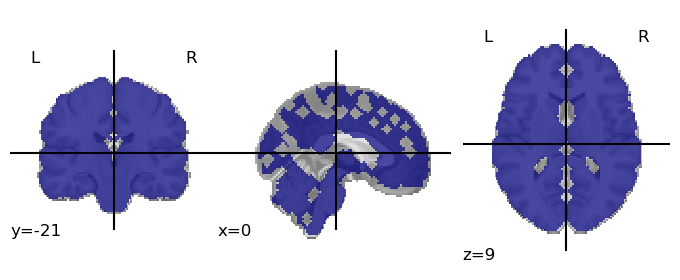

In [4]:
# create brain mask 
from nilearn.image import resample_to_img
from nilearn.masking import compute_brain_mask

anat_path = 'data/anatomy/mask.nii'
anatomy = nib.load(anat_path)
mask = compute_brain_mask(anatomy)
#anatomy = resample_to_img(anatomy, beta_maps[0])
#mask = compute_brain_mask(anatomy)

print('Shape of the mask: ', mask.shape)
from nilearn.plotting import plot_roi
plot_roi(mask_init_res)


In [5]:
from nilearn.input_data import NiftiMasker
masker = NiftiMasker(mask_img=mask)
from tqdm import tqdm
samples = []
for map in tqdm(beta_maps):
    samples.append(masker.fit_transform(map))
samples = np.concatenate(samples, axis=0)

/opt/anaconda3/envs/MVAP/lib/python3.8/site-packages/nilearn/input_data/__init__.py:27: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)
100%|███████████████████████████████████████████| 49/49 [00:17<00:00,  2.73it/s]


 Size of samples if we use the inital mask:  
 49 * 30 * 3403613   
 If we use the downsampled mask:  
 49 * 30 * 216734  
 Which is way better for computation time  

In [6]:
print(samples.shape)

(1470, 216734)


We have 49 subs, and for each of them there is 30 beta maps, which correspong to a training sample. Hence we need 30*49 labels

In [45]:
labels = np.tile(['caught', 'chase', 'checkpoint', 'close_enemy', 'protected_by_wall', 'vc_hit'], 5*nb_sub)
print('Numbers of labels/training samples: ', len(labels))

Numbers of labels/training samples:  1470


In [46]:
masked_epi = masker.inverse_transform(samples)
masked_epi.shape

(91, 109, 91, 1470)

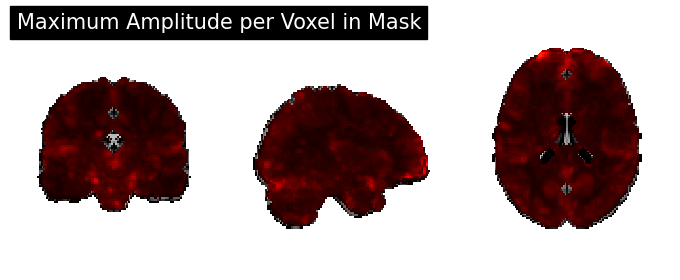

In [47]:
from nilearn.image import math_img
from nilearn.plotting import plot_stat_map

max_zscores = math_img("np.abs(img).max(axis=3)", img=masked_epi)
plot_stat_map(max_zscores, dim=-.5, cut_coords=[33, -20, 20],
              draw_cross=False, annotate=False, colorbar=False,
              title='Maximum Amplitude per Voxel in Mask')

In [48]:
# Let's specify the classifier
from sklearn.svm import SVC
clf = SVC(gamma=2, C=1, verbose=True, max_iter=50)

In [10]:
#leave on out per run 

One way to do cross-validation is the so called Leave-one-out cross-validation. This approach trains on 6 chunks, and classifies the remaining chunk (one remaining), and repeats this for every chunk, also called fold. Therefore, a 7-fold cross-validation is one that divides the whole data into 7 different chunks.

--> train classifier using the data from 6 of the 7 runs, and then  test  accuracy at classifying the unseen data from the remaining run. 
--> 7 iterations, using all 7 combination of train & test run 

In [49]:
#49 chunks : per subject per run 
chunks_sub = np.ravel([[i]*30 for i in range(49)])
chunks_sub.shape

(1470,)

In [50]:
#30 volumes per class, 1470 volumes spread over 5 runs (with 6 conditons) for one subject, 245 per condition,  : 
chunks_sub = np.ravel([[i]*30 for i in range(49)])
chunks_sub.shape

(1470,)

In [52]:
# Import from model_selection module, split subject
from sklearn.model_selection import GroupKFold

# In fact, when we initialize GroupKFold with 4 splits, as below, it is exactly the same as
# the LeaveOneGroupOut cross-validator, since we only have 4 groups
gkf = GroupKFold(n_splits=5)
for train_idx, test_idx in gkf.split(X=samples, y=labels, groups=chunks_sub):
    print("Indices of our test-samples: %r" % test_idx.tolist())
    print("... which correspond to following runs: %r" % chunks_sub[test_idx].tolist(), '\n')

Indices of our test-samples: [90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 540, 541, 542, 543, 544, 545, 546, 547, 548, 549, 550, 551, 552, 553, 554, 555, 556, 557, 558, 559, 560, 561, 562, 563, 564, 565, 566, 567, 568, 569, 840, 841, 842, 843, 844, 845, 846, 847, 848, 849, 850, 851, 852, 853, 854, 855, 856, 857, 858, 859, 860, 861, 862, 863, 864, 865, 866, 867, 868, 869, 990, 991, 992, 993, 994, 995, 996, 997, 998, 999, 1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011, 1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1140, 1141, 1142, 1143, 1144, 1145, 1146, 1147, 1148, 1149, 

In [53]:
cv_scores = cross_val_score(estimator=clf,
                            X=samples,
                            y=labels,
                            groups=chunks_sub,
                            cv=LeaveOneGroupOut(),
                            n_jobs=-1,
                            verbose=1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


WARN: libsvm Solver reached max_iter
optimization finished, #iter = 50
obj = -50.000000, rho = 0.000000
nSV = 100, nBSV = 100
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 50
obj = -50.000000, rho = 0.000000
nSV = 100, nBSV = 100
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 50
obj = -50.000000, rho = 0.000000
nSV = 100, nBSV = 100
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 50
obj = -50.000000, rho = 0.000000
nSV = 100, nBSV = 100
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 50
obj = -50.000000, rho = 0.000000
nSV = 100, nBSV = 100
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 50
obj = -50.000000, rho = 0.000000
nSV = 100, nBSV = 100
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 50
obj = -50.000000, rho = 0.000000
nSV = 100, nBSV = 100
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 50
obj = -50.000000, rho = 0.000000
nSV = 100, nBS

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 65.4min


WARN: libsvm Solver reached max_iter
optimization finished, #iter = 50
obj = -50.000000, rho = 0.000000
nSV = 100, nBSV = 100
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 50
obj = -50.000000, rho = 0.000000
nSV = 100, nBSV = 100
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 50
obj = -50.000000, rho = 0.000000
nSV = 100, nBSV = 100
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 50
obj = -50.000000, rho = 0.000000
nSV = 100, nBSV = 100
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 50
obj = -50.000000, rho = 0.000000
nSV = 100, nBSV = 100
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 50
obj = -50.000000, rho = 0.000000
nSV = 100, nBSV = 100
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 50
obj = -50.000000, rho = 0.000000
nSV = 100, nBSV = 100
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 50
obj = -50.000000, rho = 0.000000
nSV = 100, nBS

[Parallel(n_jobs=-1)]: Done  49 out of  49 | elapsed: 73.6min finished


In [54]:
print('Average accuracy = %.02f percent\n' % (cv_scores.mean() * 100))
print('Accuracy per fold:', cv_scores, sep='\n')

Average accuracy = 16.67 percent

Accuracy per fold:
[0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667
 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667
 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667
 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667
 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667
 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667
 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667
 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667
 0.16666667]
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

/opt/anaconda3/envs/MVAP/lib/python3.8/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/envs/MVAP/lib/python3.8/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/envs/MVAP/lib/python3.8/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/envs/MVAP/lib/python3.8/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/envs/MVAP/lib/python3.8/site-packages/sklearn/svm/_base.py:301: ConvergenceWa

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

/opt/anaconda3/envs/MVAP/lib/python3.8/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/envs/MVAP/lib/python3.8/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/envs/MVAP/lib/python3.8/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/envs/MVAP/lib/python3.8/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/envs/MVAP/lib/python3.8/site-packages/sklearn/svm/_base.py:301: ConvergenceWa

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

/opt/anaconda3/envs/MVAP/lib/python3.8/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/envs/MVAP/lib/python3.8/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/envs/MVAP/lib/python3.8/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/envs/MVAP/lib/python3.8/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/envs/MVAP/lib/python3.8/site-packages/sklearn/svm/_base.py:301: ConvergenceWa

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

/opt/anaconda3/envs/MVAP/lib/python3.8/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/envs/MVAP/lib/python3.8/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/envs/MVAP/lib/python3.8/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/envs/MVAP/lib/python3.8/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/envs/MVAP/lib/python3.8/site-packages/sklearn/svm/_base.py:301: ConvergenceWa

In [32]:
clf.fit(samples, labels)

[LibSVM]WARN: libsvm Solver reached max_iter
optimization finished, #iter = 100
obj = -100.000000, rho = 0.000000
nSV = 200, nBSV = 200
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 100
obj = -100.000000, rho = 0.000000
nSV = 200, nBSV = 200
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 100
obj = -100.000000, rho = 0.000000
nSV = 200, nBSV = 200
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 100
obj = -100.000000, rho = 0.000000
nSV = 200, nBSV = 200
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 100
obj = -100.000000, rho = 0.000000
nSV = 200, nBSV = 200
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 100
obj = -100.000000, rho = 0.000000
nSV = 200, nBSV = 200
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 100
obj = -100.000000, rho = 0.000000
nSV = 200, nBSV = 200
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 100
obj = -100.000000, rho =

/Users/skowronski/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(



optimization finished, #iter = 100
obj = -100.000000, rho = 0.000000
nSV = 200, nBSV = 200
Total nSV = 600


SVC(C=1, gamma=2, max_iter=100, verbose=True)

In [33]:
res = clf.predict(samples)

In [34]:
(res == labels).sum()

745

think about which kinds of classifiers would you like to use and why? <br>
which other models that are not in the tutorial would you think could be interesting to test out? <br>


### Cross validation
read the paper and emulate their CV paradigm. <br>

__potential possibilities__
- leave one run out, one model per sub
- leave one run out per sub
- leave one subject out 